#**NEURAL MACHINE TRANSLATION USING ENCODER DECODER ATTENTION MODEL**
# Translating from English to Spanish

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing, utils
import numpy as np
import matplotlib.pyplot as plt

# Downloading dataset for Spanish to English translation

In [2]:
!pip install wget
import wget
url = 'https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch08/spa.txt'
wget.download(url,'spa.txt')

# with open('spanish_eng/spa.txt',encoding='utf-8',errors='ignore') as file:
#     text = file.read().split('\n')
# text[:5]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=fea932c8adea8409ff794c64c96ef1012fcc982f644a500ce0fc4569802243b8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'spa (1).txt'

# Creating datasets for training

In [3]:
# reading data
with open('spa.txt',encoding='utf-8',errors='ignore') as file:
  text=file.read().split('\n')

In [4]:
len(text)

34795

In [5]:
text[:5] # input and target data is separated by tab '\t'

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)',
 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)',
 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)',
 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)',
 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)']

In [6]:
for t in text[100:110]:
  print(t)

Got it?	¿Entendiste?	CC-BY 2.0 (France) Attribution: tatoeba.org #455353 (CM) & #989540 (hayastan)
He ran.	Él corrió.	CC-BY 2.0 (France) Attribution: tatoeba.org #672229 (CK) & #1426322 (marcelostockle)
He ran.	Corrió.	CC-BY 2.0 (France) Attribution: tatoeba.org #672229 (CK) & #5165642 (cueyayotl)
Hop in.	Métete adentro.	CC-BY 2.0 (France) Attribution: tatoeba.org #1111548 (Scott) & #1336569 (marcelostockle)
Hug me.	Abrázame.	CC-BY 2.0 (France) Attribution: tatoeba.org #1852504 (CK) & #5769213 (arh)
I care.	Me preocupo.	CC-BY 2.0 (France) Attribution: tatoeba.org #8397687 (CK) & #8410507 (arh)
I fell.	Me caí.	CC-BY 2.0 (France) Attribution: tatoeba.org #3824714 (CK) & #5559530 (ecorralest101)
I fled.	Huí.	CC-BY 2.0 (France) Attribution: tatoeba.org #8397688 (CK) & #8410508 (arh)
I fled.	Me escapé.	CC-BY 2.0 (France) Attribution: tatoeba.org #8397688 (CK) & #8410509 (arh)
I fled.	Huía.	CC-BY 2.0 (France) Attribution: tatoeba.org #8397688 (CK) & #8410534 (arh)


In [7]:
input_texts=[] #encoder input
target_texts=[] # decoder input

In [8]:

# we will select subset of the whole data
NUM_SAMPLES = 20000
for line in text[:NUM_SAMPLES]:
  parts = line.split('\t')
  if len(parts) < 2:
    continue


  english, spanish  = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

In [9]:
print(input_texts[:5],target_texts[:5])

['go.', 'go.', 'go.', 'go.', 'hi.'] ['ve.', 'vete.', 'vaya.', 'váyase.', 'hola.']


# Data processing

In [10]:
import string
print('Characters to be removed in preprocessing', string.punctuation)

Characters to be removed in preprocessing !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
#removing punctuation from target and input
def remove_punctuation(s):
  out=s.translate(str.maketrans("","",string.punctuation))
  return out

In [12]:
input_texts = [remove_punctuation(s) for s in input_texts]
target_texts = [remove_punctuation(s) for s in target_texts]

In [13]:
input_texts[:5],target_texts[:5]

(['go', 'go', 'go', 'go', 'hi'], ['ve', 'vete', 'vaya', 'váyase', 'hola'])

In [14]:
# adding start and end tags
target_texts=['<start> ' + s + ' <end>' for s in target_texts]

In [15]:
target_texts[1]

'<start> vete <end>'

# Tokenizing Input dataset

In [16]:
tokenizer_in=Tokenizer()
#tokenizing the input texts
tokenizer_in.fit_on_texts(input_texts)
#vocab size of input
input_vocab_size=len(tokenizer_in.word_index) + 1

In [17]:
input_vocab_size

3741

In [18]:
# Listing few items
input_tokens = tokenizer_in.index_word
for k,v in sorted(input_tokens.items())[2000:2010]:
    print (k,v)

2001 plead
2002 sneeze
2003 suck
2004 glass
2005 justice
2006 fan
2007 teaching
2008 wear
2009 direct
2010 scold


# Tokenizing Output dataset

In [19]:
#tokenizing output that is spanish translation
tokenizer_out=Tokenizer(filters='')
tokenizer_out.fit_on_texts(target_texts)
#vocab size of output
output_vocab_size=len(tokenizer_out.word_index) + 1
output_vocab_size

7932

In [20]:
# Listing few items
output_tokens = tokenizer_out.index_word
for k,v in sorted(output_tokens.items())[2000:2010]:
    print (k,v)

2001 trabajó
2002 marchado
2003 disparado
2004 enciéndelo
2005 compramos
2006 reímos
2007 ¡pero
2008 ¿llamaste
2009 decides
2010 marcharse


#Creating input sequences

In [21]:
#converting tokenized sentence into sequences
tokenized_input = tokenizer_in.texts_to_sequences( input_texts )
#max length of the input
maxlen_input = max( [ len(x) for x in tokenized_input ] )
#padding sequence to the maximum length
padded_input = pad_sequences( tokenized_input , maxlen=maxlen_input , padding='post' )

In [22]:
padded_input[2000:2010]

array([[ 115,   62,    1,    0,    0],
       [ 115,   62,    1,    0,    0],
       [  47,   64,    6,    0,    0],
       [  47,  919,    6,    0,    0],
       [  47,    4,    2,    0,    0],
       [  47,  848,    0,    0,    0],
       [  47,   90,    8,    0,    0],
       [  47,  681,    0,    0,    0],
       [  47, 1437,    0,    0,    0],
       [ 153,   29,    0,    0,    0]], dtype=int32)

In [23]:
encoder_input_data = np.array( padded_input )
print( encoder_input_data.shape)

(20000, 5)


# Creating output sequences

In [24]:
#converting tokenized text into sequences
tokenized_output = tokenizer_out.texts_to_sequences(target_texts)

In [25]:
output_vocab_size=len(tokenizer_out.word_index) + 1
output_vocab_size

7932

In [26]:
# teacher forcing
for i in range(len(tokenized_output)) :
    tokenized_output[i] = tokenized_output[i][1:]

In [27]:
# padding
maxlen_output = max( [ len(x) for x in tokenized_output ] )
padded_output = pad_sequences( tokenized_output ,
                                                     maxlen=maxlen_output ,
                                                     padding='post' )

In [28]:
# converting to numpy
decoder_input_data = np.array( padded_output )
decoder_input_data[2000:2010]

array([[  68,   16,    2,    0,    0,    0,    0,    0,    0,    0],
       [ 623,  418,   16,    2,    0,    0,    0,    0,    0,    0],
       [  34,   12,   42,    2,    0,    0,    0,    0,    0,    0],
       [  34,   12, 4278,    2,    0,    0,    0,    0,    0,    0],
       [  34,    4,    3,    2,    0,    0,    0,    0,    0,    0],
       [  34,  520,   29,  497,    2,    0,    0,    0,    0,    0],
       [  34,    7, 4279,    2,    0,    0,    0,    0,    0,    0],
       [  34,   14,  354,    2,    0,    0,    0,    0,    0,    0],
       [  34,  995,    2,    0,    0,    0,    0,    0,    0,    0],
       [  34,   10,   26,    2,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [29]:
#decoder target output
decoder_target_one_hot=np.zeros((len(input_texts),
                                 maxlen_output,
                                 output_vocab_size),
                                 dtype='float32')
for i,d in enumerate(padded_output):
    for t,word in enumerate(d):
        decoder_target_one_hot[i,t,word]=1

In [30]:
decoder_target_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# The input sequence is first fed to the embedding layer which converts the words in the input sequences into word vectors. These word vectors are then passed as input to the encoder layer.


# Downloading word embedding
#### If you have not downloaded the Glove word embedding to your Google drive, uncomment the following lines to download the file.

In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #downloading glove word embedding layer
!unzip glove*.zip

# Word to Vectors dictionary

In [33]:
#creating dictionary of words corresponding to vectors
print('Indexing word vectors.')

embeddings_index = {}

# Use this open command in case of downloading using wget above
f = open('glove.6B.200d.txt', encoding='utf-8')

# we can choose any dimensions 50 100 200 300
#f = open('drive/My Drive/tfbookdata/glove.6B.200d.txt', encoding='utf-8')

# f = open('/content/drive/My Drive/TextGenerationDemo/glove.6B.200d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))






# #creating dictionary of words corresponding to vectors
# print('Indexing word vectors.')

# embeddings_index = {}

# # Use this open command in case of downloading using wget above
# f = open('glove.6B.200d.txt', encoding='utf-8')

# # we can choose any dimensions 50 100 200 300
# #f = open('drive/My Drive/tfbookdata/glove.6B.200d.txt', encoding='utf-8')

# # f = open('/content/drive/My Drive/TextGenerationDemo/glove.6B.200d.txt', encoding='utf-8')

# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 40819 word vectors.


In [34]:
embeddings_index["any"]

array([ 6.3113e-01,  4.3183e-01,  2.3103e-01, -6.4909e-01,  2.3744e-01,
        4.4619e-01, -8.6148e-01,  2.9341e-01,  8.0033e-02,  8.5633e-03,
        1.0165e-01,  6.2783e-01,  2.5047e-01,  5.2425e-02,  6.3045e-01,
       -4.0008e-02,  2.5212e-01,  6.2147e-01,  6.6967e-02, -7.9787e-02,
       -2.1607e-02,  3.4236e+00, -4.7925e-02,  2.4620e-01, -2.8834e-02,
        4.0330e-02, -2.7858e-01, -2.7939e-01,  3.5606e-01, -5.7373e-01,
       -9.9960e-02, -3.2374e-01,  1.7812e-01,  2.0671e-02,  2.3637e-01,
       -1.7074e-01, -4.9345e-01, -4.0289e-01, -3.4184e-01, -1.9405e-01,
        4.2506e-01, -3.0081e-01,  1.9997e-01,  6.7150e-01, -1.0461e-01,
       -8.7182e-03, -4.4562e-02,  1.7045e-01,  6.5912e-01,  8.9096e-02,
       -1.4178e-01, -5.8817e-01, -2.9699e-01,  4.5901e-01,  6.1475e-01,
        2.2455e-01,  2.8778e-01, -8.0486e-02, -1.6625e-01,  4.9791e-01,
       -1.0441e-02, -1.7307e-01, -1.1364e-01, -1.7177e-01,  6.5001e-01,
       -2.0709e-01, -2.5923e-03,  6.8332e-01,  1.3556e-01,  4.28

## Extracting for our input vocabulary

In [35]:
#embedding matrix
num_words = len(tokenizer_in.word_index)+1
word2idx_input = tokenizer_in.word_index
embedding_matrix = np.zeros((num_words, 200))
for word,i in word2idx_input.items():
    if i<num_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(3741, 200)

## Embedding layer

In [36]:
#lstm hidden dimensions
LATENT_DIM=512
#embeding layer dimensions
EMBEDDING_DIM=200

In [37]:
embedding_layer=Embedding(input_vocab_size,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=maxlen_input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Defining Encoder

In [38]:
#encoder
encoder_inputs = Input(shape=(maxlen_input,),
                      name = 'encoderinput')
encoder_input = embedding_layer(encoder_inputs)
encoder = Bidirectional(LSTM(LATENT_DIM,
                             return_sequences=True,
                             dropout = 0.3),
                        name = 'encoder_bidirection')
encoder_outputs = encoder(encoder_input)

In [39]:
encoder_outputs.shape

(None, 5, 1024)

# Decoder Network

In [40]:
decoder_inputs = Input(shape=(maxlen_output,),
                      name='decoder_input')
decoder_embedding = Embedding(output_vocab_size,
                             EMBEDDING_DIM,
                             name='decoder_embedding')
decoder_input=decoder_embedding(decoder_inputs)

In [41]:
decoder_input.shape

(None, 10, 200)

## Defining Decoder layers

In [42]:
#decoder lstm
decoder_lstm = LSTM(LATENT_DIM,
                    return_state = True,
                    name = 'decoder_lstm')
#decoder dense with softmax for pedicting each word
decoder_dense = Dense(output_vocab_size,
                      activation='softmax',
                      name='decoder_dense')

# Attention Network

## Defining Softmax layer

In [43]:
# Computing alphas
import tensorflow.keras.backend as k
def softmax_attention(x):
    assert(k.ndim(x)>2)

    e=k.exp(x-k.max(x,axis=1,keepdims=True))
    s=k.sum(e,axis=1,keepdims=True)
    return e/s

# Attention Layers

In [44]:
# nerual network layers for our repeated use
attention_repeat =  RepeatVector(maxlen_input)
attention_concat = Concatenate(axis=-1)
dense1_layer = Dense(10,activation='tanh')
dense2_layer = Dense(1,activation = softmax_attention)
dot_layer = Dot(axes=1)

In [45]:
# computing attention context
def context_attention(h, st_1):
    st_1=attention_repeat(st_1)
    x=attention_concat([h,st_1])
    x=dense1_layer(x)
    alphas=dense2_layer(x)
    context = dot_layer([alphas,h])
    return context

# Collecting outputs

In [46]:
#initial states to be fed
initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [47]:
s = initial_s
c = initial_c
outputs = []

#collect output in a list at first
for t in range(maxlen_output): #ty times
    #get the context using attention mechanism
    context=context_attention(encoder_outputs,s)

    #we need a different layer for each time step
    selector=Lambda(lambda x: x[:,t:t+1])
    x_t=selector(decoder_input)

    #combine
    x_t_dense = Dense(1024)(x_t)  # Match x_t to have shape (None, 1, 512)

# Combine context and the transformed x_t
    decoder_lstm_input = context_last_word_concat_layer([context, x_t_dense])


    #pass the combined [context,last word] into lstm
    #along with [s,c]
    #get the new[s,c] and output
    out,s,c=decoder_lstm(decoder_lstm_input,initial_state=[s,c])

    #final dense layer to get next word prediction
    decoder_outputs = decoder_dense(out)
    outputs.append(decoder_outputs)

In [48]:
outputs

[<KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_44>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_58>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_72>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_86>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_100>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_114>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_128>,
 <KerasTensor shape=(None, 7932), dtype=float32, sparse=False, name=keras_tensor_142>]

In [49]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

In [50]:
def stack(x):
    x=k.stack(x)
    x=k.permute_dimensions(x,pattern=(1,0,2))
    return x

In [51]:
stacker=Lambda(stack)
outputs=stacker(outputs)
outputs

<KerasTensor shape=(None, 10, 7932), dtype=float32, sparse=False, name=keras_tensor_154>


# Defining model

In [52]:
model=Model(inputs=[encoder_inputs,
                    decoder_inputs,
                    initial_s,
                    initial_c],
            outputs=outputs)

In [53]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoderinput (InputLayer) │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 5, 200)         │        748,200 │ encoderinput[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s0 (InputLayer)           │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bidirection       │ (None, 5, 1024)        │      2,920,448 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 5, 512)         │              0 │ s0[0][0],              │
│ (RepeatVector)            │                        │                │ decoder_lstm[0][1],    │
│                           │                        │                │ decoder_lstm[1][1],    │
│                           │                        │                │ decoder_lstm[2][1],    │
│                           │                        │                │ decoder_lstm[3][1],    │
│                           │                        │                │ decoder_lstm[4][1],    │
│                           │                        │                │ decoder_lstm[5][1],    │
│                           │                        │                │ decoder_lstm[6][1],    │
│                           │                        │                │ decoder_lstm[7][1],    │
│                           │                        │                │ decoder_lstm[8][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5, 1536)        │              0 │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[0][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[1][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[2][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[3][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[4][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[5][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[6][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[7][0],   │
│                           │                        │                │ encoder_bidirection[0… │
│                           │                        │                │ repeat_vector[8][0],   │
│                      

 Total params: 16,642,713 (63.49 MB)

 Trainable params: 16,642,713 (63.49 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# tf.keras.utils.plot_model (model)

In [55]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [56]:
#to improve GPU speed
from tensorflow.keras.mixed_precision import Policy, set_global_policy

policy = Policy('mixed_float16')  # Use mixed precision
set_global_policy(policy)

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
model_save_path = '/content/drive/My Drive/saved_models/best_model.keras'
# Ensure the directory exists
import os
os.makedirs('/content/drive/My Drive/saved_models/', exist_ok=True)

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,   # Path where the model will be saved
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only the model with the best 'val_loss'
    save_weights_only=False,    # Save the entire model (not just weights)
    mode='min',                 # Save when 'val_loss' decreases
    verbose=1                   # Print saving status to console
)

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')

Training

In [61]:
initial_s_training=np.zeros((NUM_SAMPLES,LATENT_DIM)) #initial s c
initial_c_training =np.zeros(shape=(NUM_SAMPLES,LATENT_DIM))
r=model.fit([encoder_input_data,
             decoder_input_data,
             initial_s_training,
             initial_c_training],
            decoder_target_one_hot,
            batch_size=100,
            epochs=200,
            validation_split=0.3,
            callbacks=[checkpoint_callback])

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5970 - loss: 3.5369
Epoch 1: val_loss improved from inf to 2.79865, saving model to /content/drive/My Drive/saved_models/best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 217ms/step - accuracy: 0.5972 - loss: 3.5309 - val_accuracy: 0.5967 - val_loss: 2.7986
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6751 - loss: 2.1831
Epoch 2: val_loss improved from 2.79865 to 2.66791, saving model to /content/drive/My Drive/saved_models/best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.6752 - loss: 2.1830 - val_accuracy: 0.6221 - val_loss: 2.6679
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6842 - loss: 2.0507
Epoch 3: val_loss improved from 2.66791 to 2.60042, saving model to /content/drive/My Drive/saved_models/best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.6842 - loss: 2.0506 - val_accuracy: 0.6243 - val_loss: 2.6004
Epoch 4/200

# Encoder model

In [62]:
encoder_model = Model(encoder_inputs, encoder_outputs)
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoderinput (InputLayer)            │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 5, 200)              │         748,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bidirection (Bidirectional)  │ (None, 5, 1024)             │       2,920,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,668,648 (13.99 MB)

 Trainable params: 3,668,648 (13.99 MB)

 Non-trainable params: 0 (0.00 B)

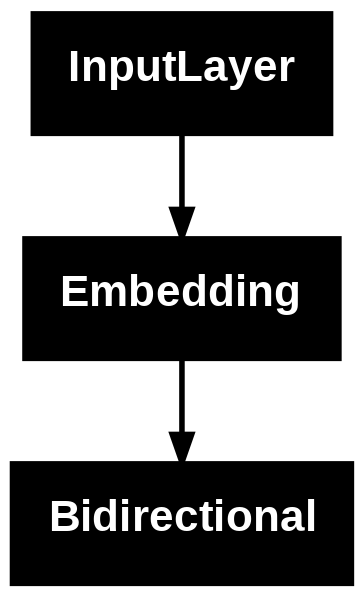

In [63]:
tf.keras.utils.plot_model (encoder_model)

# Decoder Model

In [64]:
#input will have the length double of latent dimension due to bidirectional
encoder_outputs_as_input = Input(shape=(maxlen_input, LATENT_DIM* 2,))
#we are going to predict one word at a time with input of one word
decoder_input_embedding = Input(shape=(1,))
decoder_input_ = decoder_embedding(decoder_input_embedding)

In [65]:
#calculating context
context = context_attention(encoder_outputs_as_input, initial_s)

In [66]:
decoder_lstm_input = context_last_word_concat_layer(
    [context, decoder_input_])

In [67]:
out, s, c = decoder_lstm(decoder_lstm_input,
                       initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(out)

In [68]:
decoder_model = Model(
  inputs=[
    decoder_input_embedding,
    encoder_outputs_as_input,
    initial_s,
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)
decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ s0 (InputLayer)           │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 5, 1024)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 5, 512)         │              0 │ s0[0][0]               │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5, 1536)        │              0 │ input_layer[0][0],     │
│                           │                        │                │ repeat_vector[10][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5, 10)          │         15,370 │ concatenate[10][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5, 1)           │             11 │ dense[10][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1, 1024)        │              0 │ dense_1[10][0],        │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, 1, 200)         │      1,586,400 │ input_layer_1[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1, 1224)        │              0 │ dot[10][0],            │
│ (Concatenate)             │                        │                │ decoder_embedding[1][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c0 (InputLayer)           │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 512), (None,   │      5,244,928 │ concatenate_1[10][0],  │
│                           │ 512), (None, 512)]     │                │ s0[0][0], c0[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 7932)           │      4,069,116 │ decoder_lstm[10][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,915,825 (41.64 MB)

 Trainable params: 10,915,825 (41.64 MB)

 Non-trainable params: 0 (0.00 B)

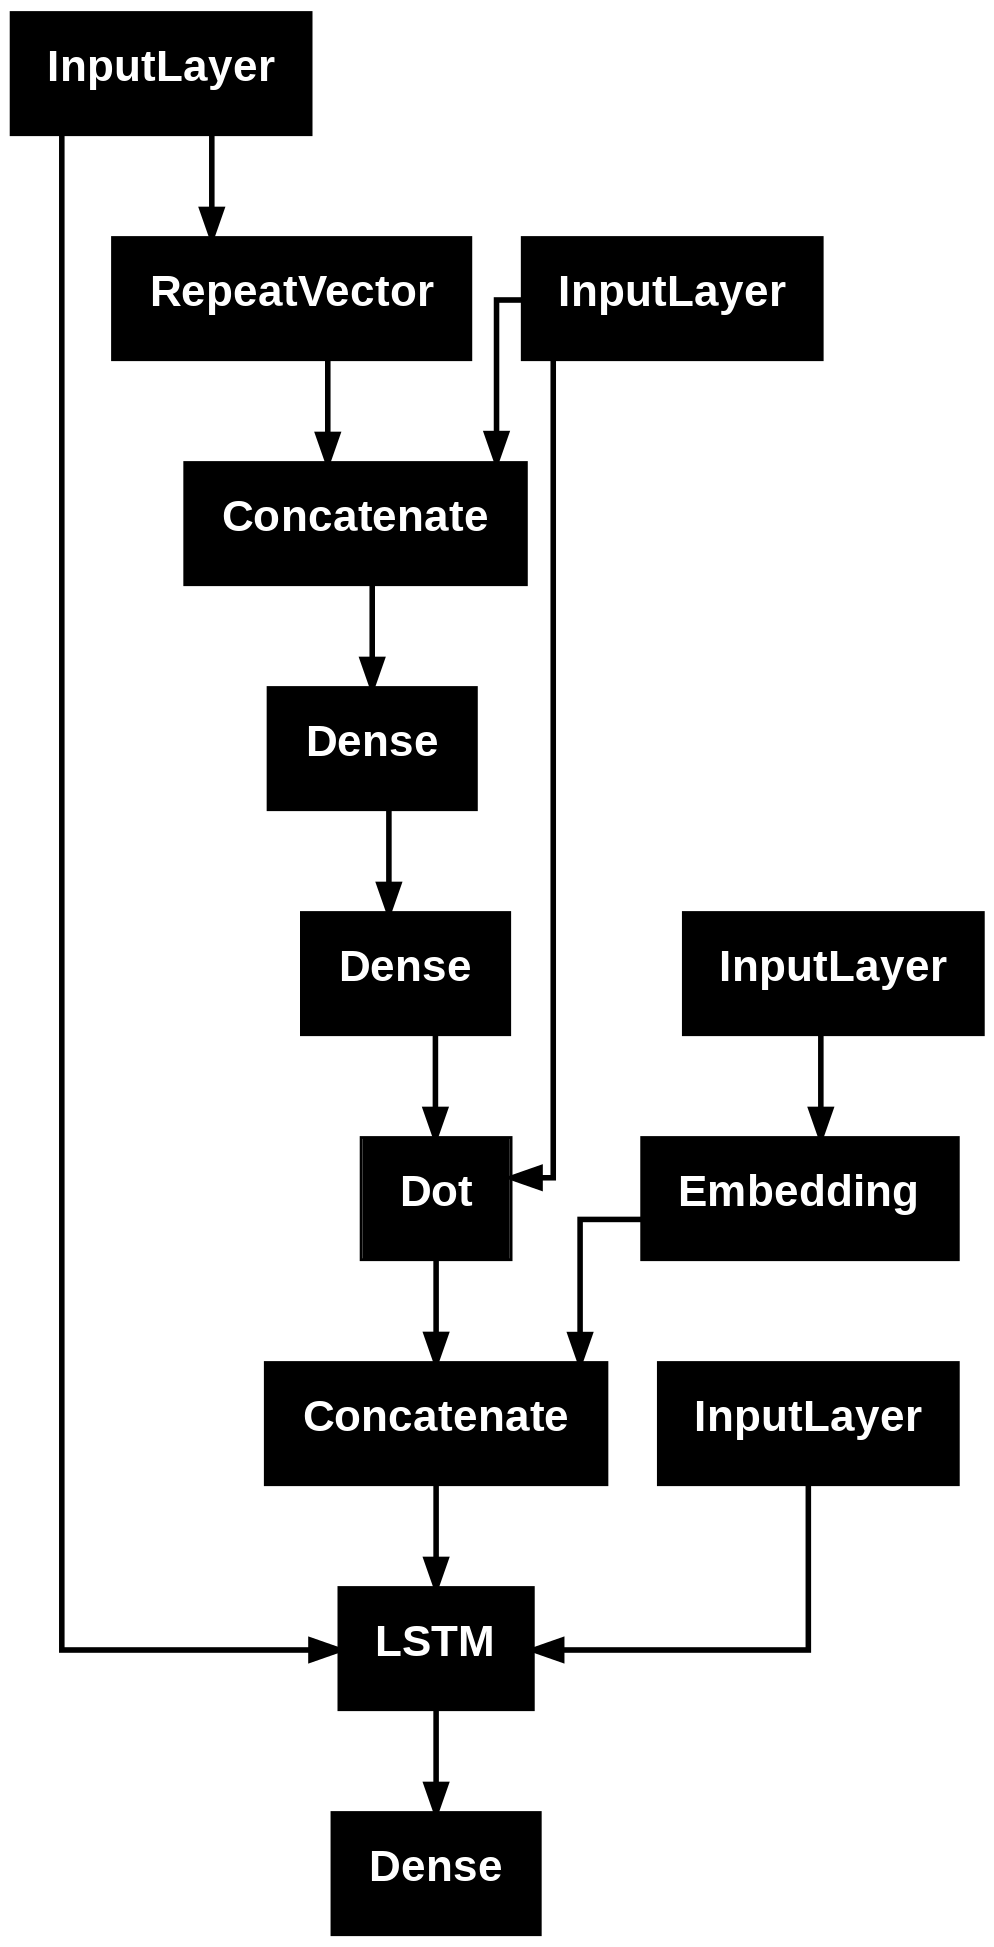

In [69]:
#tf.keras.utils.plot_model (decoder_model,to_file='decoder_model.jpg')
tf.keras.utils.plot_model (decoder_model)

# Translating

In [70]:
word2index_input=tokenizer_in.word_index
word2index_output=tokenizer_out.word_index
#reverse mapping integer to words for english
idx2word_eng = {v:k for k, v in word2index_input.items()}
#reverse mapping integer to words for spanish
idx2word_trans = {v:k for k, v in word2index_output.items()}

In [71]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2index_output['<start>']

  # if we get this we break
  End_statement = word2index_output['<end>']

  # [s, c] will be updated in each loop iteration
  s = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))

  # Create the translation
  output_sentence = []
  for _ in range(maxlen_output):
    out, s, c = decoder_model.predict([target_seq, enc_out, s, c])

    # Get next word
    index = np.argmax(out.flatten())

    # End sentence
    if End_statement == index:
      break

    word = ''
    if index > 0:
      word = idx2word_trans[index]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = index

  return ' '.join(output_sentence)

In [ ]:
count=0
while (count<5):

  input_text=[str(input('input the sentence : '))]
  seq=tokenizer_in.texts_to_sequences(input_text)

  input_seq=pad_sequences(seq,maxlen=maxlen_input,padding='post')
  translation=decode_sequence(input_seq)

  print('Predicted translation:', translation)
  count+=1

input the sentence : hi hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted translation: inútil aburrido luce ponte ponte ponte ponte ponte ponte ponte
input the sentence : what is your name
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predict

In [ ]:
English------Malayalam Text